In [1407]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [1408]:
# Inventory Data
inventory_df = pd.read_json('./data/exported_listings.json')
stock_df = pd.read_json('./data/stock_listing_v1_1.json')
inventory_df = inventory_df.merge(stock_df, on='_id')
inventory_df = inventory_df[['date', 'title', 'category', 'unit_cost', 'current_stock', 'avg_usage_per_day']]
inventory_df.sort_values('date', inplace=True)

# ABC Model Cluster Results Data
abc_clusters_df = pd.read_csv('./data/abc_clusters.csv')

In [1409]:
inventory_df

,date,title,category,unit_cost,current_stock,avg_usage_per_day
0,2022-01-01,Ventilator,Equipment,2628329,22,5
2080,2022-01-01,Defibrilator,Equipment,650745,6,0
3121,2022-01-01,Wheelchair,Equipment,15486,23,0
5177,2022-01-01,ECG Machine,Equipment,314121,2,2
6211,2022-01-01,MRI Scanner,Equipment,40522506,1,1
...,...,...,...,...,...,...
14487,2024-12-31,Syringe,Consumable,20,5990,680
1023,2024-12-31,Ventilator,Equipment,1852964,22,1
15536,2024-12-31,Bandages,Consumable,11,3405,430
9310,2024-12-31,Gloves,Consumable,13,4101,708


In [1410]:
abc_clusters_df

,title,year,month,category,unit_cost,beginning_inventory,ending_inventory,annual_usage_value,monthly_usage,annual_usage,stock_turnover_rate,stock_variability,ABC_category
0,Antiseptic Solution,2022,2022-01,Consumable,4.554325e+02,958,2474,4.591761e+07,8401.833333,100822,4.896173,0.504353,C
1,Antiseptic Solution,2022,2022-02,Consumable,4.554325e+02,2762,2992,4.591761e+07,8401.833333,100822,2.920345,0.504353,C
2,Antiseptic Solution,2022,2022-03,Consumable,4.554325e+02,2227,1903,4.591761e+07,8401.833333,100822,4.068684,0.504353,C
3,Antiseptic Solution,2022,2022-04,Consumable,4.554325e+02,2246,2570,4.591761e+07,8401.833333,100822,3.489133,0.504353,C
4,Antiseptic Solution,2022,2022-05,Consumable,4.554325e+02,2524,562,4.591761e+07,8401.833333,100822,5.445129,0.504353,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...
643,X-Ray-Machine,2024,2024-08,Equipment,3.744346e+06,5,8,5.841180e+08,13.000000,156,24.000000,0.504353,B
644,X-Ray-Machine,2024,2024-09,Equipment,3.744346e+06,5,8,5.841180e+08,13.000000,156,24.000000,0.504353,B
645,X-Ray-Machine,2024,2024-10,Equipment,3.744346e+06,5,8,5.841180e+08,13.000000,156,24.000000,0.504353,B
646,X-Ray-Machine,2024,2024-11,Equipment,3.744346e+06,5,8,5.841180e+08,13.000000,156,24.000000,0.504353,B


<h2 style="padding: 0.5rem; background-color: #513d5c; color: white;">Feature Engineering</h2>

In [1412]:
inventory_df['date'] = pd.to_datetime(inventory_df['date']) # Preprocessing: Datetime Conversion
inventory_df['month'] = inventory_df['date'].dt.to_period('M')
inventory_df = inventory_df[['date', 'month', 'title', 'category', 'unit_cost', 'current_stock', 'avg_usage_per_day']]
inventory_df

,date,month,title,category,unit_cost,current_stock,avg_usage_per_day
0,2022-01-01,2022-01,Ventilator,Equipment,2628329,22,5
2080,2022-01-01,2022-01,Defibrilator,Equipment,650745,6,0
3121,2022-01-01,2022-01,Wheelchair,Equipment,15486,23,0
5177,2022-01-01,2022-01,ECG Machine,Equipment,314121,2,2
6211,2022-01-01,2022-01,MRI Scanner,Equipment,40522506,1,1
...,...,...,...,...,...,...,...
14487,2024-12-31,2024-12,Syringe,Consumable,20,5990,680
1023,2024-12-31,2024-12,Ventilator,Equipment,1852964,22,1
15536,2024-12-31,2024-12,Bandages,Consumable,11,3405,430
9310,2024-12-31,2024-12,Gloves,Consumable,13,4101,708


In [1413]:
inventory_df = inventory_df.copy().sort_values('date')
inventory_df['stock_diff'] = inventory_df.groupby(['title', 'month'])[['current_stock']].transform(lambda x: x.diff())
inventory_df['restock_quantity'] = inventory_df.groupby(['title', 'month'])['stock_diff'].transform(lambda x: x.clip(lower=0))
inventory_df

,date,month,title,category,unit_cost,current_stock,avg_usage_per_day,stock_diff,restock_quantity
0,2022-01-01,2022-01,Ventilator,Equipment,2628329,22,5,NaN,NaN
1024,2022-01-01,2022-01,X-Ray-Machine,Equipment,4384823,1,0,NaN,NaN
17613,2022-01-01,2022-01,Cotton Rolls,Consumable,107,1148,234,NaN,NaN
15537,2022-01-01,2022-01,Blood Bags,Consumable,1059,1294,31,NaN,NaN
14488,2022-01-01,2022-01,Bandages,Consumable,32,2603,580,NaN,NaN
...,...,...,...,...,...,...,...,...,...
16583,2024-12-31,2024-12,Blood Bags,Consumable,820,1315,56,387.0,387.0
3120,2024-12-31,2024-12,Defibrilator,Equipment,300543,7,0,0.0,0.0
9310,2024-12-31,2024-12,Gloves,Consumable,13,4101,708,524.0,524.0
10340,2024-12-31,2024-12,IV Drip,Consumable,134,867,96,-160.0,0.0


In [1414]:
# Checker
inventory_df[inventory_df['title'] == 'Infusion Pump']
inventory_df[(inventory_df['title'] == 'Ventilator') & (inventory_df['month'] == '2024-01')]
inventory_df[(inventory_df['title'] == 'ECG Machine') & (inventory_df['month'] == '2024-01')]

,date,month,title,category,unit_cost,current_stock,avg_usage_per_day,stock_diff,restock_quantity
5865,2024-01-01,2024-01,ECG Machine,Equipment,186390,10,0,NaN,NaN
5866,2024-01-02,2024-01,ECG Machine,Equipment,385218,8,0,-2.0,0.0
5867,2024-01-03,2024-01,ECG Machine,Equipment,179955,4,1,-4.0,0.0
5868,2024-01-04,2024-01,ECG Machine,Equipment,226666,6,1,2.0,2.0
5869,2024-01-05,2024-01,ECG Machine,Equipment,375334,7,3,1.0,1.0
5870,2024-01-06,2024-01,ECG Machine,Equipment,316872,8,2,1.0,1.0
5871,2024-01-07,2024-01,ECG Machine,Equipment,155132,3,0,-5.0,0.0
5872,2024-01-08,2024-01,ECG Machine,Equipment,383392,5,0,2.0,2.0
5873,2024-01-09,2024-01,ECG Machine,Equipment,324662,6,3,1.0,1.0
5874,2024-01-10,2024-01,ECG Machine,Equipment,247025,6,0,0.0,0.0


In [1415]:
restock_df = inventory_df.groupby(['title', 'month'])[['restock_quantity']].sum().reset_index()
restock_df

,title,month,restock_quantity
0,Antiseptic Solution,2022-01,14287.0
1,Antiseptic Solution,2022-02,8499.0
2,Antiseptic Solution,2022-03,14556.0
3,Antiseptic Solution,2022-04,12011.0
4,Antiseptic Solution,2022-05,11653.0
...,...,...,...
643,X-Ray-Machine,2024-08,41.0
644,X-Ray-Machine,2024-09,52.0
645,X-Ray-Machine,2024-10,53.0
646,X-Ray-Machine,2024-11,35.0


In [1416]:
# Create a MONTHLY BASED BEGINNING/ENDING INVENTORY FOR EQUIPMENT (It was annually-based on imported data)
inventory_df['date'] = pd.to_datetime(inventory_df['date'])
inventory_df['month'] = inventory_df['date'].dt.to_period('M')
inventory_df['year'] = inventory_df['date'].dt.to_period('Y')

monthly_start_end_stock = inventory_df.groupby(['title', 'month']).agg(
        beginning_inventory_monthly = ('current_stock', 'first'),
        ending_inventory_monthly = ('current_stock', 'last'),
).reset_index()

restock_df = restock_df.merge(monthly_start_end_stock, on=['title', 'month'])
restock_df

,title,month,restock_quantity,beginning_inventory_monthly,ending_inventory_monthly
0,Antiseptic Solution,2022-01,14287.0,958,2474
1,Antiseptic Solution,2022-02,8499.0,2762,2992
2,Antiseptic Solution,2022-03,14556.0,2227,1903
3,Antiseptic Solution,2022-04,12011.0,2246,2570
4,Antiseptic Solution,2022-05,11653.0,2524,562
...,...,...,...,...,...
643,X-Ray-Machine,2024-08,41.0,9,8
644,X-Ray-Machine,2024-09,52.0,4,8
645,X-Ray-Machine,2024-10,53.0,9,3
646,X-Ray-Machine,2024-11,35.0,8,4


In [1417]:
# Preparation for Merge
restock_df['month'] = abc_clusters_df['month'].astype(str)

# Merge to ABC Clusters (to merge for beginning/ending inventory)
restock_df1 = restock_df.merge(abc_clusters_df, on=['title', 'month'])
restock_df1

,title,month,restock_quantity,beginning_inventory_monthly,ending_inventory_monthly,year,category,unit_cost,beginning_inventory,ending_inventory,annual_usage_value,monthly_usage,annual_usage,stock_turnover_rate,stock_variability,ABC_category
0,Antiseptic Solution,2022-01,14287.0,958,2474,2022,Consumable,4.554325e+02,958,2474,4.591761e+07,8401.833333,100822,4.896173,0.504353,C
1,Antiseptic Solution,2022-02,8499.0,2762,2992,2022,Consumable,4.554325e+02,2762,2992,4.591761e+07,8401.833333,100822,2.920345,0.504353,C
2,Antiseptic Solution,2022-03,14556.0,2227,1903,2022,Consumable,4.554325e+02,2227,1903,4.591761e+07,8401.833333,100822,4.068684,0.504353,C
3,Antiseptic Solution,2022-04,12011.0,2246,2570,2022,Consumable,4.554325e+02,2246,2570,4.591761e+07,8401.833333,100822,3.489133,0.504353,C
4,Antiseptic Solution,2022-05,11653.0,2524,562,2022,Consumable,4.554325e+02,2524,562,4.591761e+07,8401.833333,100822,5.445129,0.504353,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
643,X-Ray-Machine,2024-08,41.0,9,8,2024,Equipment,3.744346e+06,5,8,5.841180e+08,13.000000,156,24.000000,0.504353,B
644,X-Ray-Machine,2024-09,52.0,4,8,2024,Equipment,3.744346e+06,5,8,5.841180e+08,13.000000,156,24.000000,0.504353,B
645,X-Ray-Machine,2024-10,53.0,9,3,2024,Equipment,3.744346e+06,5,8,5.841180e+08,13.000000,156,24.000000,0.504353,B
646,X-Ray-Machine,2024-11,35.0,8,4,2024,Equipment,3.744346e+06,5,8,5.841180e+08,13.000000,156,24.000000,0.504353,B


In [1418]:
restock_df1['demand'] = restock_df1['beginning_inventory_monthly'] - restock_df1['ending_inventory_monthly'] + restock_df1['restock_quantity']
restock_df1[['title', 'month', 'demand']]

,title,month,demand
0,Antiseptic Solution,2022-01,12771.0
1,Antiseptic Solution,2022-02,8269.0
2,Antiseptic Solution,2022-03,14880.0
3,Antiseptic Solution,2022-04,11687.0
4,Antiseptic Solution,2022-05,13615.0
...,...,...,...
643,X-Ray-Machine,2024-08,42.0
644,X-Ray-Machine,2024-09,48.0
645,X-Ray-Machine,2024-10,59.0
646,X-Ray-Machine,2024-11,39.0


In [1419]:
restock_df1.dtypes

title                           object
month                           object
restock_quantity               float64
beginning_inventory_monthly      int64
ending_inventory_monthly         int64
year                             int64
category                        object
unit_cost                      float64
beginning_inventory              int64
ending_inventory                 int64
annual_usage_value             float64
monthly_usage                  float64
annual_usage                     int64
stock_turnover_rate            float64
stock_variability              float64
ABC_category                    object
demand                         float64
dtype: object

In [1420]:
restock_df1['month'] = pd.to_datetime(restock_df1['month']).dt.to_period('M')
restock_df1.asfreq('MS')
restock_df1

,title,month,restock_quantity,beginning_inventory_monthly,ending_inventory_monthly,year,category,unit_cost,beginning_inventory,ending_inventory,annual_usage_value,monthly_usage,annual_usage,stock_turnover_rate,stock_variability,ABC_category,demand
0,Antiseptic Solution,2022-01,14287.0,958,2474,2022,Consumable,4.554325e+02,958,2474,4.591761e+07,8401.833333,100822,4.896173,0.504353,C,12771.0
1,Antiseptic Solution,2022-02,8499.0,2762,2992,2022,Consumable,4.554325e+02,2762,2992,4.591761e+07,8401.833333,100822,2.920345,0.504353,C,8269.0
2,Antiseptic Solution,2022-03,14556.0,2227,1903,2022,Consumable,4.554325e+02,2227,1903,4.591761e+07,8401.833333,100822,4.068684,0.504353,C,14880.0
3,Antiseptic Solution,2022-04,12011.0,2246,2570,2022,Consumable,4.554325e+02,2246,2570,4.591761e+07,8401.833333,100822,3.489133,0.504353,C,11687.0
4,Antiseptic Solution,2022-05,11653.0,2524,562,2022,Consumable,4.554325e+02,2524,562,4.591761e+07,8401.833333,100822,5.445129,0.504353,C,13615.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
643,X-Ray-Machine,2024-08,41.0,9,8,2024,Equipment,3.744346e+06,5,8,5.841180e+08,13.000000,156,24.000000,0.504353,B,42.0
644,X-Ray-Machine,2024-09,52.0,4,8,2024,Equipment,3.744346e+06,5,8,5.841180e+08,13.000000,156,24.000000,0.504353,B,48.0
645,X-Ray-Machine,2024-10,53.0,9,3,2024,Equipment,3.744346e+06,5,8,5.841180e+08,13.000000,156,24.000000,0.504353,B,59.0
646,X-Ray-Machine,2024-11,35.0,8,4,2024,Equipment,3.744346e+06,5,8,5.841180e+08,13.000000,156,24.000000,0.504353,B,39.0


<div style="width: 30%;">
    <h3 style="background-color: #a07fb3; color: white; padding: 0.5rem 0.5rem; text-align: center; vertical-align: middle; box-shadow: 5px 5px #4d3e66;">🎯 Demand Analysis</h3>
    <div style="margin: 1.5rem 0;"></div>
</div>

In [1422]:
restock_df_analysis = restock_df1.copy()
restock_df_analysis['month'] = restock_df_analysis['month'].dt.to_timestamp()

In [1423]:
restock_df_analysis.dtypes

title                                  object
month                          datetime64[ns]
restock_quantity                      float64
beginning_inventory_monthly             int64
ending_inventory_monthly                int64
year                                    int64
category                               object
unit_cost                             float64
beginning_inventory                     int64
ending_inventory                        int64
annual_usage_value                    float64
monthly_usage                         float64
annual_usage                            int64
stock_turnover_rate                   float64
stock_variability                     float64
ABC_category                           object
demand                                float64
dtype: object

In [1424]:
restock_df_analysis['title'].unique()

array(['Antiseptic Solution', 'Bandages', 'Blood Bags', 'Cotton Rolls',
       'Defibrilator', 'ECG Machine', 'Face Shield', 'Gloves', 'Gown',
       'Hospital Bed', 'IV Drip', 'Infusion Pump', 'MRI Scanner',
       'Surgical Mask', 'Syringe', 'Ventilator', 'Wheelchair',
       'X-Ray-Machine'], dtype=object)

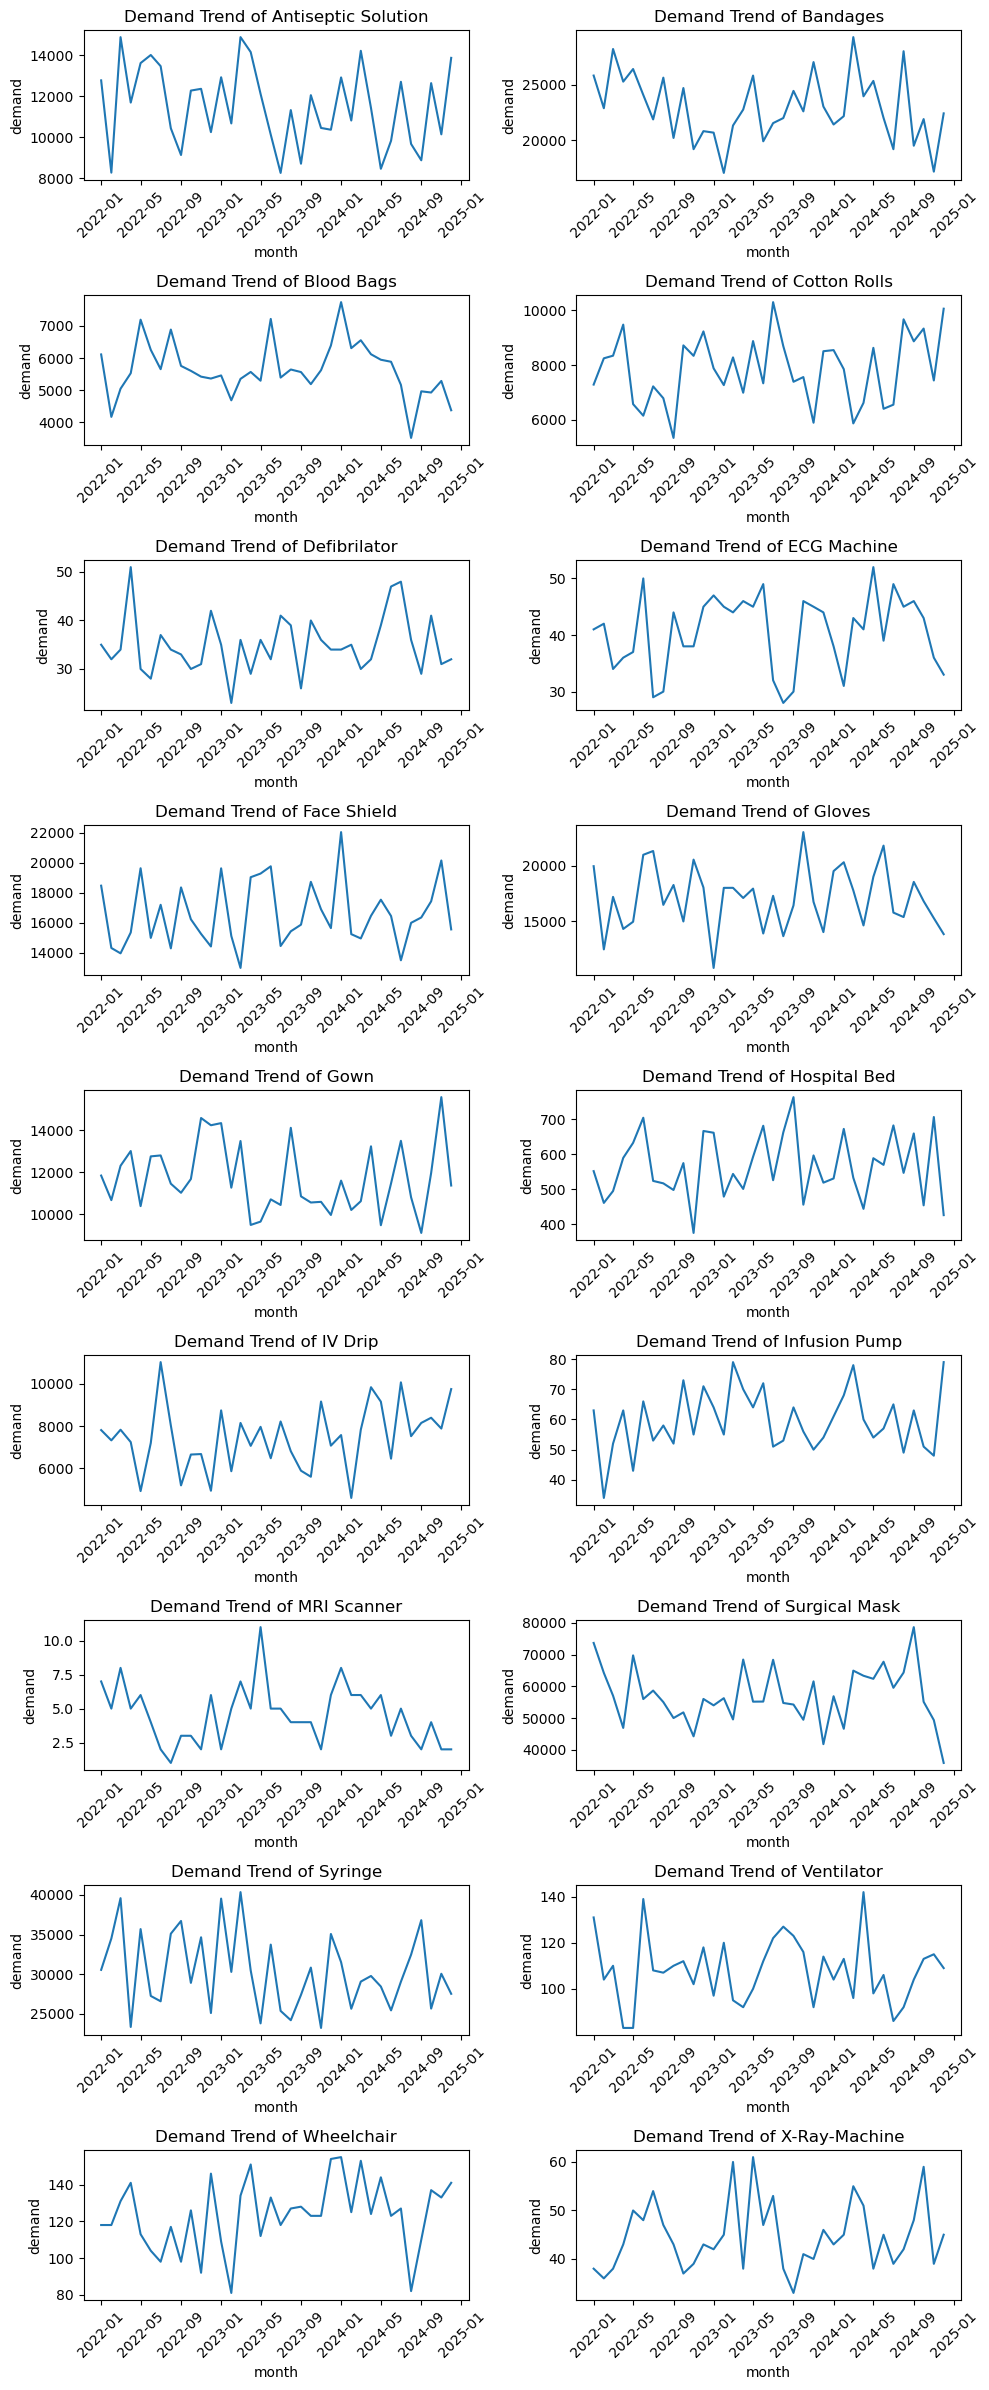

In [1425]:
fig, axes = plt.subplots(int(len(restock_df_analysis['title'].unique())/2), 2, figsize=(10, 24))
row_cnt = 0
col_loop = 0

for item in restock_df1['title'].unique():
    sns.lineplot(restock_df_analysis[restock_df_analysis['title'] == f'{item}'], x='month', y='demand', ax=axes[row_cnt, col_loop])
    axes[row_cnt, col_loop].set_title(f'Demand Trend of {item}')
    axes[row_cnt, col_loop].tick_params(axis='x', rotation=45)

    if col_loop == 1:
        row_cnt += 1
    col_loop =  1 - col_loop
    
plt.tight_layout()
plt.show()

<h2 style="padding: 0.5rem; background-color: #513d5c; color: white;">Model Training</h2>

In [1427]:
# Augmented Dickey-Fuller Test (ADF) --> stationarity check for the ARIMA
def adf_test(series):
    result = adfuller(series)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    if result[1] <= 0.05:
        print('✅ Data is stationary.')
        return True
    else:
        print('❌ Data is NOT stationary. Differencing is needed.')
        return False

In [1428]:
# Data Preprocessing
restock_df1 = pd.get_dummies(restock_df1, columns=['ABC_category'], prefix='ABC')
restock_df1[['ABC_A', 'ABC_B', 'ABC_C']] = restock_df1[['ABC_A', 'ABC_B', 'ABC_C']].astype(int)

scaler = StandardScaler()
restock_df1[['restock_quantity']] = scaler.fit_transform(restock_df1[['restock_quantity']])

In [1468]:
item_name = 'MRI Scanner'
X = restock_df1[restock_df1['title'] == f'{item_name}'][['title', 'month', 'demand', 'restock_quantity', 'ABC_A', 'ABC_B', 'ABC_C']].copy()
#X = restock_df1[restock_df1['title'] == f'{item_name}'][['title', 'month', 'demand', 'ABC_A', 'ABC_B', 'ABC_C']].copy()
X = X.set_index('month')
X.drop('title', axis=1, inplace=True)

In [1469]:
# Data Split
mask = (X.index < '2024-06')
X_train = X[mask].copy()
X_test = X[~mask].copy()

In [1470]:
# Check demand stationarity using ADF
is_stationary = adf_test(X_train['demand'])

# Perform auto_arima to find the best (p,d,q) order
stepwise_fit = auto_arima(X_train['demand'], seasonal=False, stepwise=True, suppress_warnings=True, trace=True)
p, d, q = stepwise_fit.order

# Fit SARIMAX Model with exogenous variables
model = SARIMAX(X_train['demand'], 
                order=(p, d, q),
                seasonal_order=(1, 1, 1, 3),
                exog=X_train[['restock_quantity', 'ABC_A', 'ABC_B', 'ABC_C']],
                #exog=X_train[['ABC_A', 'ABC_B', 'ABC_C']],
                enforce_stationarity=False,
                enforce_invertibility=False)
model_fit = model.fit()
print(model_fit.summary())

ADF Statistic: -3.941665234960557
p-value: 0.001748736529201742
✅ Data is stationary.
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=140.345, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=181.812, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=141.865, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=165.694, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=137.743, Time=0.03 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=155.742, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=136.579, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=137.636, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=135.884, Time=0.01 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=137.500, Time=0.02 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=137.008, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=130.073, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=130.120, Time=0.01 sec
 ARIMA(3,0,0)(0,0,0)[0] in

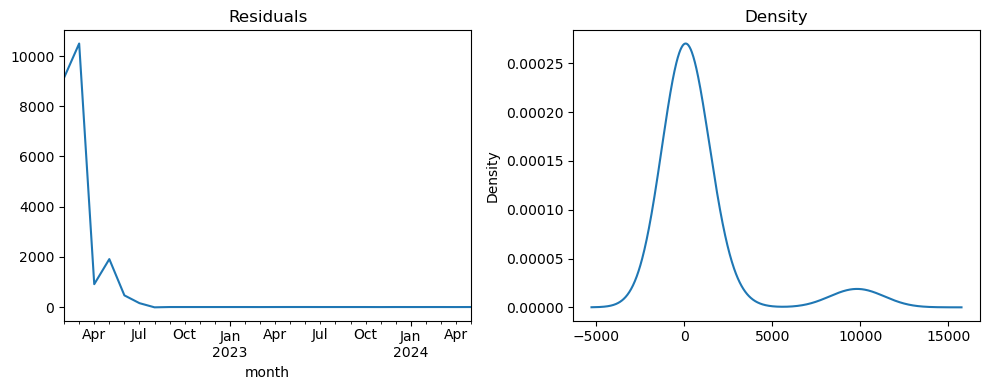

In [1471]:
residuals = model_fit.resid[1:]
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde', ax=ax[1])
plt.tight_layout()
plt.show()

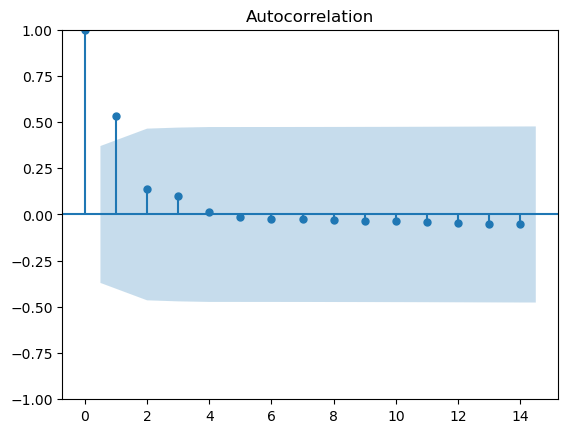

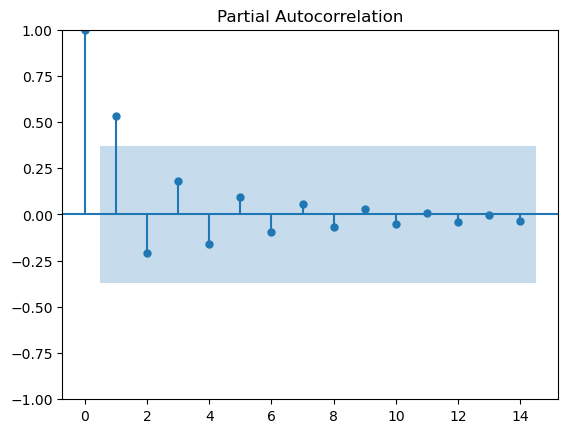

In [1472]:
acf_res = plot_acf(residuals)
pacf_res = plot_pacf(residuals)

<h2 style="padding: 0.5rem; background-color: #513d5c; color: white;">Model Evaluation</h2>

In [1474]:
# Forecast Future Demand
future_steps = len(X_test)
future_exog = pd.DataFrame({
    'restock_quantity': [X['restock_quantity'].mean()] * future_steps,
    'ABC_A': [X_train['ABC_A'].mean()] * future_steps,
    'ABC_B': [X_train['ABC_B'].mean()] * future_steps,
    'ABC_C': [X_train['ABC_C'].mean()] * future_steps
})

forecast = model_fit.forecast(steps=future_steps, exog=future_exog)


print(f'ITEM NAME: {item_name}')
print(forecast)

ITEM NAME: MRI Scanner
2024-06    4.892865
2024-07    4.624429
2024-08    4.553714
2024-09    4.611549
2024-10    4.492267
2024-11    4.620165
2024-12    4.662699
Freq: M, Name: predicted_mean, dtype: float64


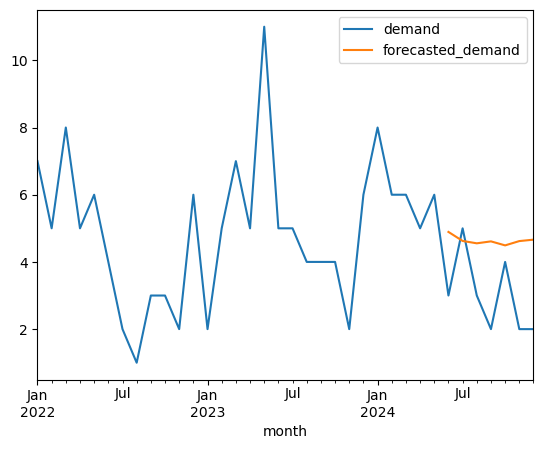

In [1475]:
# Forecast Actual vs Predicted
X['forecasted_demand'] = [None]*len(X_train) + list(forecast)
X[['demand', 'forecasted_demand']].plot()
plt.show()

In [1476]:
def mean_absolute_percentage_error(y_actual, y_predicted):
    return np.mean(np.abs((y_actual - y_predicted) / y_actual)) * 100

# Calculate RMSE
# Extract actual demand values for comparison
y_actual = X_test['demand']
y_predicted = forecast

# Compute RMSE
rmse = np.sqrt(mean_squared_error(y_actual, y_predicted))

# Compute MAPE
mape = mean_absolute_percentage_error(y_actual, y_predicted)

# Print Results
print(f'RMSE: {rmse:.2f}')
print(f'MAPE: {mape:.2f}%')

RMSE: 1.97
MAPE: 75.63%


In [1477]:
'''
#X_features = ['title', 'month', 'demand']
X_features = ['title', 'month', 'demand', 'restock_quantity', 'ABC_category']
X_all = restock_df1[X_features]

# One-hot encode the ABC_category
X_all = pd.get_dummies(X_all, columns=['ABC_category'], prefix='ABC')
X_all[['ABC_A', 'ABC_B', 'ABC_C']] = X_all[['ABC_A', 'ABC_B', 'ABC_C']].astype(int)

# Scale data
scaler = StandardScaler()
X[['restock_quantity']] = scaler.fit_transform(X[['restock_quantity']])

for item in X_all['title'].unique():
    
    # Filter data for the specific item
    X = X_all[X_all['title'] == item].copy()
    X = X.set_index('month')
    X = X.drop('title', axis=1)

    # Transform demand to avoid negative trends
    X['demand_log'] = np.log1p(X['demand'])
    
    # DATA STATIONARITY CHECK
    print(f'\nITEM NAME: {item}')
    is_stationary = adf_test(X['demand'])
    
    if not is_stationary:
        X['demand_diff'] = X['demand'].diff()
        X.dropna(inplace=True)
        stepwise_fit = auto_arima(X['demand_diff'], seasonal=False, stepwise=True, suppress_warnings=True, trace=True)
        #stepwise_fit = auto_arima(
         #   X['demand'], seasonal=True, d=1, stepwise=True, suppress_warnings=True, trace=True
        #)
        p, d, q = stepwise_fit.order
        #P, D, Q, s = stepwise_fit.seasonal_order
        model = SARIMAX(
            X['demand'],
            exog=X[['restock_quantity', 'ABC_A', 'ABC_B', 'ABC_C']], 
            order=(p, d, q),
            #seasonal_order=(P, D, Q, s)
        )

    else:
        stepwise_fit = auto_arima(X['demand'], seasonal=False, stepwise=True, suppress_warnings=True, trace=True)
        #stepwise_fit = auto_arima(
         #   X['demand'], seasonal=True, d=1, stepwise=True, suppress_warnings=True, trace=True
        #)
        p, d, q = stepwise_fit.order
        #P, D, Q, s = stepwise_fit.seasonal_order
        model = SARIMAX(
            X['demand'], 
            exog=X[['restock_quantity', 'ABC_A', 'ABC_B', 'ABC_C']], 
            order=(p, d, q), 
            #seasonal_order=(P, D, Q, s)
        )
    
    # MODEL FITTING
    model_fit = model.fit()
    print(model_fit.summary())

    # DEMAND FORECASTING
    future_steps = 30

    # Generate future exogenous values
    mean_restock = X['restock_quantity'].mean() if not X['restock_quantity'].isna().all() else 0  
    future_exog = pd.DataFrame({
        'restock_quantity': [mean_restock] * future_steps,
        'ABC_A': [int('ABC_A' in X.columns)] * future_steps,
        'ABC_B': [int('ABC_B' in X.columns)] * future_steps,
        'ABC_C': [int('ABC_C' in X.columns)] * future_steps
    })


    # Forecasting with exogenous variables
    forecast = model_fit.forecast(steps=future_steps, exog=future_exog)
    
    print(f'ITEM NAME: {item}')
    print(forecast)
'''

"\n#X_features = ['title', 'month', 'demand']\nX_features = ['title', 'month', 'demand', 'restock_quantity', 'ABC_category']\nX_all = restock_df1[X_features]\n\n# One-hot encode the ABC_category\nX_all = pd.get_dummies(X_all, columns=['ABC_category'], prefix='ABC')\nX_all[['ABC_A', 'ABC_B', 'ABC_C']] = X_all[['ABC_A', 'ABC_B', 'ABC_C']].astype(int)\n\n# Scale data\nscaler = StandardScaler()\nX[['restock_quantity']] = scaler.fit_transform(X[['restock_quantity']])\n\nfor item in X_all['title'].unique():\n    \n    # Filter data for the specific item\n    X = X_all[X_all['title'] == item].copy()\n    X = X.set_index('month')\n    X = X.drop('title', axis=1)\n\n    # Transform demand to avoid negative trends\n    X['demand_log'] = np.log1p(X['demand'])\n    \n    # DATA STATIONARITY CHECK\n    print(f'\nITEM NAME: {item}')\n    is_stationary = adf_test(X['demand'])\n    \n    if not is_stationary:\n        X['demand_diff'] = X['demand'].diff()\n        X.dropna(inplace=True)\n        stepw